In [1]:
# Along-fjord Layer Properties
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
import gsw

In [2]:
## Test to identity layer interface
File02 = xr.open_dataset('/work/oceans/wbao/MITgcm_results/iceplume/Sal_Linear_minhs/state_001.nc')
File2 = File02.isel(T=~File02.get_index("T").duplicated())
T0 = 90
Tn = len(File2.T)
State = File2.isel(X=range(260), Xp1=range(261), Y=range(35,45), Yp1=range(35,45))
U = State.U.data.mean(2)
u = (U[:,:,1:] + U[:,:,:-1]) / 2


In [15]:
uz = u[80,:,100]
l = np.where(uz > 0)[-1]
uz[l[0]-1:l[-1]+2]

(array([-0.0035592 ,  0.00623714,  0.01453831,  0.01350771,  0.01011559,
         0.01203448,  0.01676721,  0.02041963,  0.02384619,  0.02508933,
         0.02542318,  0.02525112,  0.02457895,  0.02388319,  0.02327915,
         0.02204453,  0.02078921,  0.0193368 ,  0.01773637,  0.01585233,
         0.01392319,  0.01204393,  0.00977138,  0.00748918,  0.00504984,
         0.00259603,  0.00014183, -0.00226288], dtype=float32),
 array([-0.0035592], dtype=float32))

In [2]:

def DynamicalP(datapath,case_id):
      
    File1 = xr.open_dataset(datapath + '/grid_' + str(format(case_id,'03d'))  + '.nc')
    File02 = xr.open_dataset(datapath + '/state_' + str(format(case_id,'03d')) + '.nc')
    File2 = File02.isel(T=~File02.get_index("T").duplicated())
    T0 = 90
    Tn = len(File2.T)
    Grid = File1.isel(X=range(260), Xp1=range(261), Y=range(35,45))
    State = File2.isel(X=range(260), Xp1=range(261), Y=range(35,45), Yp1=range(35,45), T=range(T0,Tn))

    x = Grid.X.data
    z = Grid.Z.data
    drF = Grid.drF.data # r cell face separation
    HFacC = Grid.HFacC.data.mean(1) # vertical fraction of open cell at cell center
    U = State.U.data.mean(axis=(0,2))
    u = (U[:, 1:] + U[:, :-1]) / 2
    s = State.S.data.mean(axis=(0,2)) # Salinity
    pt = State.Temp.data.mean(axis=(0,2)) # Potential temperature
    pres = gsw.p_from_z(z, 55)
    p = np.tile(pres,[len(x),1]).T
    rho = gsw.rho(s, pt, p) # Density
    g = 9.81
    
    Sma = np.ma.masked_where(s==0, s)
    s1 = np.empty(len(x))
    s2 = np.empty(len(x))
    u1 = np.empty(len(x))
    u2 = np.empty(len(x))
    F1 = np.empty(len(x))
    F2 = np.empty(len(x))
    L = np.empty(len(x))
    for i in range(1,len(x)):
        gh = drF * HFacC[:,i] # grid height
        meanS = np.abs(Sma[:,i] - (Sma[:,i].max() + Sma[:,i].min()) / 2)
        #l = np.argmin(meanS) # index of the layer interface
        l = np.where(u[:, i] < 0)[-1][0]
        h1 = gh[:l].sum()    
        h2 = gh[l+1:].sum()
        s1[i] = np.sum(s[:l,i] * gh[:l]) / h1
        s2[i] = np.sum(s[l+1:,i] * gh[l+1:]) / h2
        u1[i] = np.sum(u[:l,i] * gh[:l]) / h1
        u2[i] = np.sum(u[l+1:,i] * gh[l+1:]) / h2
        
        rho1 = np.sum(rho[:l,i] * gh[:l]) / h1
        rho2 = np.sum(rho[l+1:,i] * gh[l+1:]) / h2
        gr = g * (rho2-rho1) / rho2 # Reduced gravity
        F1[i] = u1[i] / np.sqrt(gr*h1)
        F2[i] = u2[i] / np.sqrt(gr*h2)
        L[i] = gr
    return (s1, s2, u1, u2, F1, F2)

In [17]:
# Layer Froude number (surface inflow - & subsurface outflow +)
def Froude_r(datapath, case_id, time):
      
    File1 = xr.open_dataset(datapath + '/grid_' + str(format(case_id,'03d'))  + '.nc')
    File02 = xr.open_dataset(datapath + '/state_' + str(format(case_id,'03d')) + '.nc')
    File2 = File02.isel(T=~File02.get_index("T").duplicated())
    #T0 = 90
    #Tn = len(File2.T)
    Grid = File1.isel(X=range(260), Xp1=range(261), Y=range(35,45))
    State = File2.isel(X=range(260), Xp1=range(261), Y=range(35,45), Yp1=range(35,45))

    x = Grid.X.data
    z = Grid.Z.data
    drF = Grid.drF.data # r cell face separation
    HFacC = Grid.HFacC.data.mean(1) # vertical fraction of open cell at cell center
    U = State.U.data.mean(2)
    u = (U[time, :, 1:] + U[time, :, :-1]) / 2
    s = State.S.data[time,:,:,:].mean(1) # Salinity
    pt = State.Temp.data[time,:,:,:].mean(1) # Potential temperature
    pres = gsw.p_from_z(z, 55)
    p = np.tile(pres,[len(x),1]).T
    rho = gsw.rho(s, pt, p) # Density
    g = 9.81
    
    s1 = np.empty(len(x))
    s2 = np.empty(len(x))
    u1 = np.empty(len(x))
    u2 = np.empty(len(x))
    F1 = np.empty(len(x))
    F2 = np.empty(len(x))
    
    for i in range(1,len(x)):
        gh = drF * HFacC[:,i] # grid height
        top = np.where(u[:, i] > 0)[-1][0] # Subsurface outflow upper boundary
        bot = np.where(u[:, i] > 0)[-1][-1] # Subsurface outflow lower boundary
        h1 = gh[:top].sum()    
        h2 = gh[top:bot+1].sum()
        s1[i] = np.sum(s[:top,i] * gh[:top]) / h1
        s2[i] = np.sum(s[top:bot+1,i] * gh[top:bot+1]) / h2
        u1[i] = np.sum(u[:top,i] * gh[:top]) / h1
        u2[i] = np.sum(u[top:bot+1,i] * gh[top:bot+1]) / h2
        
        rho1 = np.sum(rho[:top,i] * gh[:top]) / h1
        rho2 = np.sum(rho[top:bot+1,i] * gh[top:bot+1]) / h2
        gr = g * (rho2-rho1) / rho2 # Reduced gravity
        F1[i] = u1[i] / np.sqrt(gr*h1)
        F2[i] = u2[i] / np.sqrt(gr*h2)
        
    return (F1, F2)

In [3]:
datapath = '/work/oceans/wbao/MITgcm_results/iceplume/1_BaseCase/'
case_n = np.array([1,2,3,4,5])
hsr = np.array([0.04,0.06,0.08,0.10,0.12])
qsg = np.array([100,250,500,1000])
dist = xr.open_dataset(datapath + '/state_001.nc').X.data[:260] / 1000

Fr1 = np.empty([len(case_n), len(dist)])
Fr2 = np.empty([len(case_n), len(dist)])
S1 = np.empty([len(case_n), len(dist)])
S2 = np.empty([len(case_n), len(dist)])
U1 = np.empty([len(case_n), len(dist)])
U2 = np.empty([len(case_n), len(dist)])

for j in range(len(case_n)):
    S1[j,:], S2[j,:], U1[j,:], U2[j,:], Fr1[j,:], Fr2[j,:] = DynamicalP(datapath, case_n[j])
    

In [ ]:
datapath1 = '/work/oceans/wbao/MITgcm_results/iceplume/2_Qsg_maxhs/'
datapath2 = '/work/oceans/wbao/MITgcm_results/iceplume/2_Qsg_minhs/'
case_n = np.array([4,5,6])
qsg = np.array([250,500,1000])
dist = xr.open_dataset(datapath1 + '/state_001.nc').X.data[:260] / 1000

Fr11 = np.empty([len(case_n), len(dist)])
Fr21 = np.empty([len(case_n), len(dist)])
S11 = np.empty([len(case_n), len(dist)])
S21 = np.empty([len(case_n), len(dist)])
U11 = np.empty([len(case_n), len(dist)])
U21 = np.empty([len(case_n), len(dist)])


Fr12 = np.empty([len(case_n), len(dist)])
Fr22 = np.empty([len(case_n), len(dist)])
S12 = np.empty([len(case_n), len(dist)])
S22 = np.empty([len(case_n), len(dist)])
U12 = np.empty([len(case_n), len(dist)])
U22 = np.empty([len(case_n), len(dist)])

for j in range(len(case_n)):
    S11[j,:], S21[j,:], U11[j,:], U21[j,:], Fr11[j,:], Fr21[j,:] = DynamicalP(datapath1,case_n[j])
    S12[j,:], S22[j,:], U12[j,:], U22[j,:], Fr12[j,:], Fr22[j,:] = DynamicalP(datapath2,case_n[j])

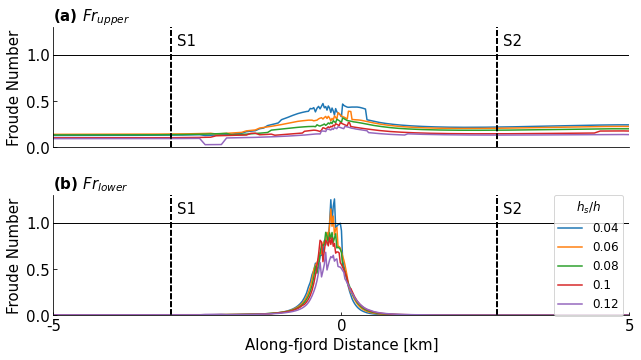

In [9]:
x0 = 2
Fr1[:,:x0] = 'nan'
Fr2[:,:x0] = 'nan'


fig1 = plt.figure(figsize=(10,5))
fig1.tight_layout()

ax1 = fig1.add_subplot(211)
ax2 = fig1.add_subplot(212)


for k in range(len(case_n)):
    ax1.plot(dist,Fr1[k,:],lw=1.5,label=str(hsr[k]))
    #ax1.legend(title=r'$h_s/h$',title_fontsize=12,fontsize=12, loc="center left")
    ax1.axhline(y=1, color='k',lw=.5)
    ax1.axvline(x=dist[120], color='k', linestyle='--')
    ax1.axvline(x=dist[235], color='k', linestyle='--')
    ax1.set_ylabel(r'Froude Number',size=15)
    ax1.set_xlim([10, 20])
    ax1.set_ylim([0, 1.3])
    ax1.xaxis.set_visible(False) # This erases the y ticks
    ax1.tick_params(direction='in',labelsize=15)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.set_title('(a) $Fr_{upper}$', loc='left', size=15, weight='bold')

    ax2.plot(dist,-Fr2[k,:],lw=1.5,label=str(hsr[k]))
    ax2.legend(title=r'$h_s/h$',title_fontsize=12,fontsize=12, loc="right")
    ax2.axhline(y=1, color='k',lw=.5)
    ax2.axvline(x=dist[120], color='k', linestyle='--')
    ax2.axvline(x=dist[235], color='k', linestyle='--')
    ax2.set_ylabel(r'Froude Number',size=15)
    ax2.set_xlabel(r'Along-fjord Distance [km]',size=15)
    ax2.set_xlim([10, 20])
    ax2.set_xticks([10, 15, 20])
    ax2.set_xticklabels(["-5","0","5"])
    ax2.set_ylim([0, 1.3])
    ax2.tick_params(direction='in',labelsize=15)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.set_title('(b) $Fr_{lower}$', loc='left', size=15, weight='bold')

# Add section name
ax1.text(dist[121],1.1,'S1',fontsize=15)
ax1.text(dist[236],1.1,'S2',fontsize=15)
ax2.text(dist[121],1.1,'S1',fontsize=15)
ax2.text(dist[236],1.1,'S2',fontsize=15)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.4)
plt.show()    

In [ ]:
# x0 = 2
# Fr11[:,:x0] = 'nan'
# Fr21[:,:x0] = 'nan'


fig2 = plt.figure(figsize=(10,5))
fig2.tight_layout()

ax1 = fig2.add_subplot(211)
ax2 = fig2.add_subplot(212)


for k in range(len(case_n)):
    ax1.plot(dist,-Fr21[k,:],lw=1.5,label=str(qsg[k]))
    #ax1.legend(title=r'$h_s/h$',title_fontsize=12,fontsize=12, loc="center left")
    ax1.axhline(y=1, color='k',lw=.5)
    ax1.axvline(x=dist[120], color='k', linestyle='--')
    ax1.axvline(x=dist[235], color='k', linestyle='--')
    ax1.set_ylabel(r'$Fr_{lower}$',size=15)
    ax1.set_xlim([10, 20])
    ax1.set_ylim([0, 1.5])
    ax1.xaxis.set_visible(False) # This erases the y ticks
    ax1.tick_params(direction='in',labelsize=15)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.set_title('(a) $h_s/h=0.12$', loc='left', size=15, weight='bold')
    
    ax2.plot(dist,-Fr22[k,:],lw=1.5,label=str(qsg[k]))
    ax2.legend(title=r'$Q_{sg} [m^3/s]$',title_fontsize=12,fontsize=12, loc="right")
    ax2.axhline(y=1, color='k',lw=.5)
    ax2.axvline(x=dist[120], color='k', linestyle='--')
    ax2.axvline(x=dist[235], color='k', linestyle='--')
    ax2.set_ylabel(r'$Fr_{lower}$',size=15)
    ax2.set_xlabel(r'Along-fjord Distance [km]',size=15)
    ax2.set_xlim([10, 20])
    ax2.set_xticks([10, 15, 20])
    ax2.set_xticklabels(["-5","0","5"])
    ax2.set_ylim([0, 1.5])
    ax2.tick_params(direction='in',labelsize=15)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.set_title('(b) $h_s/h=0.04$', loc='left', size=15, weight='bold')
      
plt.show()    

In [31]:
# Examine Froude number for the Stratification cases
datapath = '/work/oceans/wbao/MITgcm_results/iceplume/Sal_Linear_minhs/'
case_n = 1
dist = xr.open_dataset(datapath + '/state_001.nc').X.data[:260] / 1000

#Fr1 = np.empty([len(case_n), len(dist)])
#Fr2 = np.empty([len(case_n), len(dist)])

fr1, fr2 = Froude_r(datapath, case_n, 100)


In [30]:
fr1.max()

6.94153776203505e-310

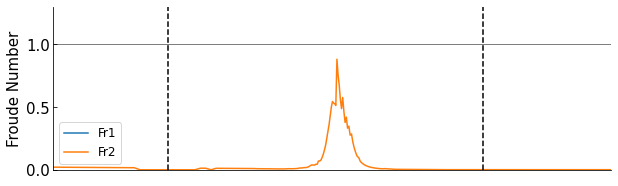

In [32]:
# Making plot for the Stratification cases
fig3 = plt.figure(figsize=(10,3))
fig3.tight_layout()

ax1 = fig3.add_subplot(111)


ax1.plot(dist,fr1,lw=1.5,label=r'Fr1')
ax1.plot(dist,fr2,lw=1.5,label=r'Fr2')
ax1.legend(fontsize=12, loc="best")
ax1.axhline(y=1, color='k',lw=.5)
ax1.axvline(x=dist[120], color='k', linestyle='--')
ax1.axvline(x=dist[235], color='k', linestyle='--')
ax1.set_ylabel(r'Froude Number',size=15)
ax1.set_xlim([10, 20])
ax1.set_ylim([0, 1.3])
ax1.xaxis.set_visible(False) # This erases the y ticks
ax1.tick_params(direction='in',labelsize=15)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
#ax1.set_title('(a) $Fr_{upper}$', loc='left', size=15, weight='bold')
plt.show()

In [10]:
fig_path ="/home/1959/Jupyter_Figs/FjordModeling/"
if not os.path.exists(fig_path):
    os.makedirs(fig_path)
fig1.savefig(fig_path + '/3-Froude.png', dpi=300, bbox_inches='tight') 
#fig2.savefig(fig_path + '/Qsg-Froude.png', dpi=200, bbox_inches='tight') 